In [1]:
path_to_package = "D:/git/WaterLily.jl"
push!(LOAD_PATH, path_to_package)

using WaterLily

using Plots
using LinearAlgebra: norm2

include("D:/git/WaterLily.jl/examples/TwoD_Plots.jl")

sim_gif! (generic function with 1 method)

In [2]:
function flowInterp(xi, arr)
    """
    Interpolates values from a 2D array arr using the coordinates xi.

    Arguments
        xi: A 2-element vector specifying the coordinates for interpolation.
        arr: A 2D array of values to interpolate from.
    Returns
        The interpolated value at the given coordinates xi.
    
    The function performs bilinear interpolation to compute the value at
    the coordinates xi within the arr array. The interpolation is based
    on the nearest grid points surrounding xi in arr.

    Example call: pos = [120.1, 51.5]; ui = flowInterp(pos, circ.flow.u[:, :, 1])
    """
    
    # Index below the interpolation coordinate.
    ii = [
        max(1, min(size(arr, 1)-1, Int(floor(xi[1])))),
        max(1, min(size(arr, 2)-1, Int(floor(xi[2]))))]
    
    # Local coordinate system <0, 1>. delta is 1 in both directions
    a = 1. / ((2 - 1) * (2 - 1))
    xx = [ii[1]+1 - xi[1], xi[1] - ii[1]]
    yy = [ii[2]+1 - xi[2], xi[2] - ii[2]]
    
    # Interp
    data = arr[ii[1]:ii[1]+1, ii[2]:ii[2]+1]
    b = data*yy
    res = a*(transpose(xx)*b)
    return res
end

function random_point_in_circle(x0::Float64, y0::Float64, r::Float64)
    # Generate a random angle between 0 and 2π
    angle = rand() * 2*pi
    
    # Generate a random radius between 0 and r
    # Using sqrt(rand()) generates a radius that is proportional
    # to the square root of a uniformly distributed random variable,
    # which results in a uniform distribution of points within the circle.
    # This is known as the polar coordinates method for generating
    # random points within a circle.
    radius = sqrt(rand()) * r
    
    # Calculate the x and y coordinates of the point
    x_point = x0 + radius * cos(angle)
    y_point = y0 + radius * sin(angle)
    
    # Return the x and y coordinates as a tuple
    return vcat(x_point, y_point)
end

function circle_shape(x0::Float64, y0::Float64, r::Float64, nPts::Int64=101)
    angles = LinRange(0, 2*pi, nPts)
    x = x0 .+ r .* cos.(angles)
    y = y0 .+ r .* sin.(angles)
    return x, y
end

circle_shape (generic function with 2 methods)

In [3]:
# Prepare
function circle(n, m, R, center; Re=250)
    U = 1.
    ν = U*R/Re
    body = AutoBody((x,t)->norm2(x .- center) - R)
    Simulation((n+2, m+2), [U, 0.], R; ν, body)
end

# Create an instance.
N = 3*2^7
M = 2^8
R = M/32.
println("radius = ", R)
x0 = [M/2, M/2]
circ = circle(N, M, R, x0)

# Prepare time values.
duration = 300
step_size = 0.5

# RL domain size.
x0Start = [10., -4.1] .* R .+ x0
Rstart = 4*R
x0End = [10., 4.1] .* R .+ x0
Rend = 4*R
rlDomainMin = [1.0, -10.0] .* R .+ x0
rlDomainMax = [20.0, 10.0] .* R .+ x0

# Random start time after the transients have been removed from the flow.
tStart = rand(100:200)
duration += tStart

# Maximum velocity of the swimmer.
Vmax = 1.2

# Time values.
t = range(0, duration; step=step_size);

radius = 8.0


In [4]:
# Generate random start and end points.
xStart = random_point_in_circle(x0Start[1], x0Start[2], Rstart)
xEnd = random_point_in_circle(x0End[1], x0End[2], Rend)

# Initial condition.
pos = copy(xStart)
vSet = [0, 0]
vFlow = [0, 0]

# Data for the swimmer.
swimmer_data = []

# Run
@time for t_i in t
    # Advance the flow.
    sim_step!(circ, t_i)
    
    if t_i > tStart
        # Retrieve the flow velocity.
        vFlow = [flowInterp(pos, circ.flow.u[:, :, 1]),
                flowInterp(pos, circ.flow.u[:, :, 2])]

        # Compute the direction to the target.
        vecToTarget = xEnd .- pos
        dToTarget = norm2(vecToTarget)
        vecToTarget /= max(1e-6, dToTarget)

        # Use theta pointing to the target.
        theta = atan(vecToTarget[2], vecToTarget[1])
        if theta >= 0
            theta = theta
        else
            theta = 2*pi+theta
        end
        theta = max(0, min(2*pi, theta))  # for good measure

        # Set velocity along the desired heading (from RL or naive control).
        vSet = [cos(theta), sin(theta)] .* Vmax

        # Update position using the Euler approach.
        pos = pos .+ (vSet .+ vFlow) .* step_size

        # Store the stats.
        push!(swimmer_data, vcat(pos, vSet, vFlow))
    
        # Print an update.
        # println("tU/L=", round(t_i, digits=4), ", Δt=", round(circ.flow.Δt[end], digits=3),
        #     ", x=(", round(pos[1], digits=3), ", ", round(pos[2], digits=3), "), d_target=", round(dToTarget, digits=3))
    else
        # println("tU/L=", round(t_i, digits=4), ", Δt=", round(circ.flow.Δt[end], digits=3))
    end
end

106.701940 seconds (9.79 M allocations: 1.405 GiB, 0.22% gc time, 2.52% compilation time)


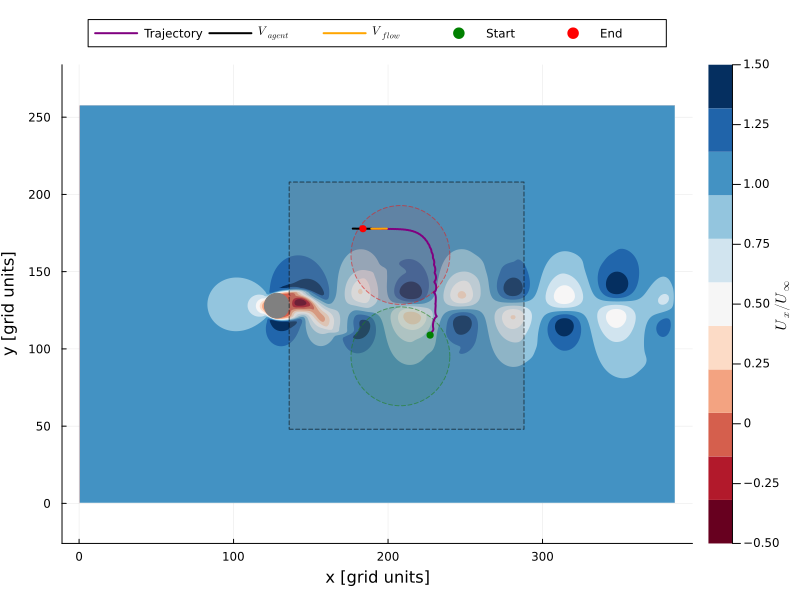

In [5]:
# Plot the flow.
gr(show=false; size=(800, 600))
flood(circ.flow.u[:, :, 1]; shift=(-0.5, -0.5), clims=(-0.5, 1.5),
    xlabel="x [grid units]", ylabel="y [grid units]", colorbar_title="\$U_{x}/U_{\\infty}\$")

# Plot the cylinder
plot!(circle_shape(x0[1], x0[2], R), fillalpha=1, linecolor=:grey, c=:grey, lw=1, seriestype=[:shape,], label="")

# Plot the start and end regions
plot!(circle_shape(x0Start[1], x0Start[2], Rstart), fillalpha=0.1,
    linecolor=:green, c=:green, line=(1, :dash, 0.6), seriestype=[:shape,], label="")
plot!(circle_shape(x0End[1], x0End[2], Rend), fillalpha=0.1,
    linecolor=:red, c=:red, line=(1, :dash, 0.6), seriestype=[:shape,], label="")

# Plot the bounds for the agent.
plot!(Shape([rlDomainMin[1], rlDomainMax[1], rlDomainMax[1], rlDomainMin[1]],
            [rlDomainMin[2], rlDomainMin[2], rlDomainMax[2], rlDomainMax[2]]),
            fillalpha=0.5, fillopacity=0.25, color=:grey, label="", lc=:black, line=(1, :dash, 0.6))

# Plot the trajectory.
plot!([x[1] for x in swimmer_data], [x[2] for x in swimmer_data], c=:purple, lw=2, label="Trajectory")

# Plot the final agent speed and flow velocity.
vscale = 10
plot!([pos[1], pos[1]+vSet[1]*vscale], [pos[2], pos[2]+vSet[2]*vscale], label="\$V_{agent}\$", lc=:black, lw=2)
plot!([pos[1], pos[1]+vFlow[1]*vscale], [pos[2], pos[2]+vFlow[2]*vscale], label="\$V_{flow}\$", lc=:orange, lw=2)

# Plot the start and end positions.
scatter!([xStart[1]], [xStart[2]], label="Start", c=:green, ms=4, markerstrokewidth=0)
scatter!([xEnd[1]], [xEnd[2]], label="End", c=:red, ms=4, markerstrokewidth=0)

# Move the legend outside.
plot!(legend=:outertop, legendcolumns=5)

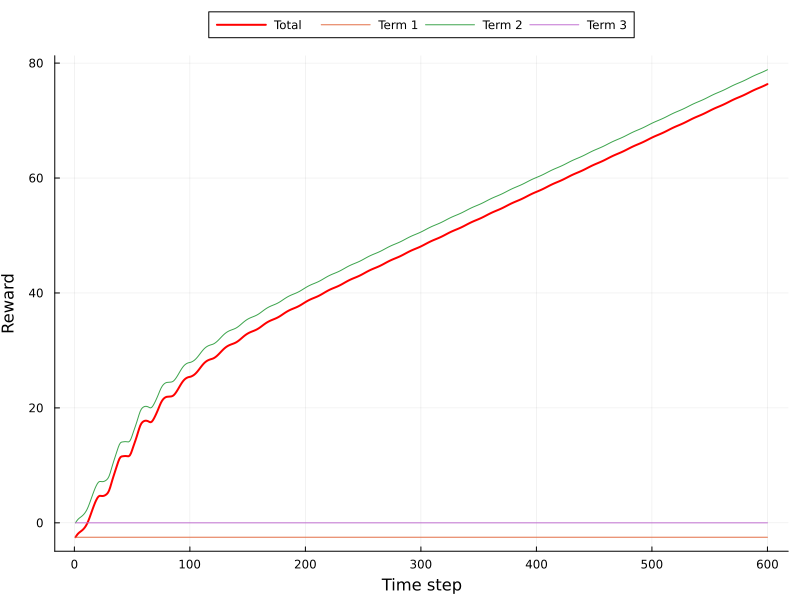

In [6]:
# Check the reward function
Vmax = 1.2
dTargetThresholdSuccess = 0.1
rewards = []
terms = []
dTargetOld = norm2(xEnd .- swimmer_data[1][1:2])

for i in 1:length(swimmer_data)
    pos = swimmer_data[i][1:2]
    vecToTarget = xEnd .- pos
    dToTarget = norm2(vecToTarget)
    vecToTarget /= max(1e-6, dToTarget)
    
    if dToTarget < dTargetThresholdSuccess*R
        bonus = 200
    else
        bonus = 0
    end
    
    push!(terms, vcat(-5*step_size, 10*(dTargetOld - dToTarget)/R/Vmax, bonus))
    reward = -5*step_size + 10*(dTargetOld - dToTarget)/R/Vmax + bonus
    
    push!(rewards, reward)
end

plot(rewards, xlabel="Time step", ylabel="Reward", c=:red, lw=2, label="Total")
plot!([x[1] for x in terms], lw=1, label="Term 1")
plot!([x[2] for x in terms], lw=1, label="Term 2")
plot!([x[3] for x in terms], lw=1, label="Term 3")
plot!(legend=:outertop, legendcolumns=4)

In [48]:
points = transpose([1 2 3 4 5; 2 4 6 8 10])
n = size(points, 1)

5

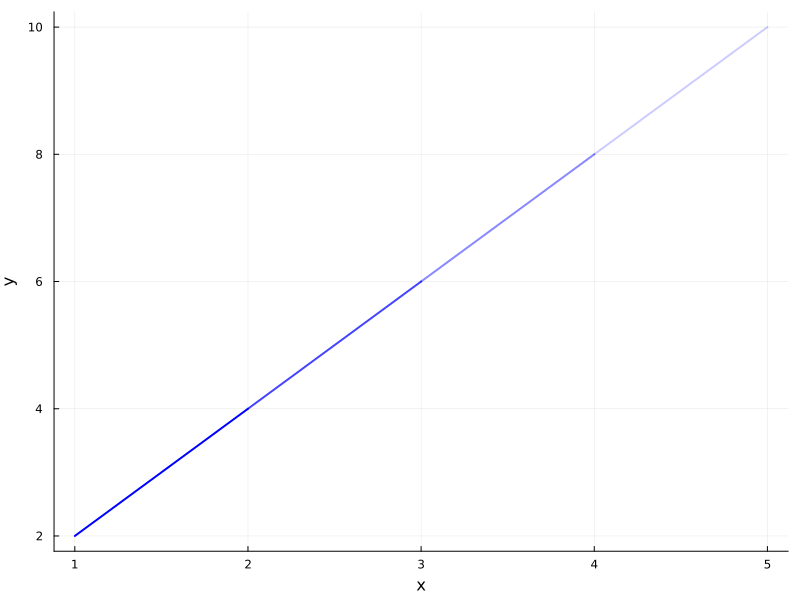

In [58]:
alphas = range(1.0, stop=0.2, length=n-1)  # Generate a range of alpha values

begin
	plot(xlabel="x", legend=false)
    for i in 1:n-1
        # scatter!(points[i:i+1, 1], points[i:i+1, 2])
        plot!(points[i:i+1, 1], points[i:i+1, 2], color=:blue, alpha=alphas[i], linewidth=2)
    end
	plot!(ylabel="y")
end